In [38]:
import numpy as np
from enum import Enum
import random as rnd
import random
import numpy as np
import matplotlib.pyplot as plt
import copy
from sklearn.metrics import mean_squared_error

In [ ]:
operators = {'+': np.add,
             '-': np.subtract,
             '/': np.divide,
             '^': np.power,
             'sin': np.sin,
             '*': np.multiply,
             'cos': np.cos}
terminals = ['x', 'y']

min_operand = -5
max_operand = 5


In [ ]:
class Type(Enum):
    Operator = 0
    Operand = 1

def operands_count(operator):
    if operator =='sin' or operator == 'cos':
        return 1
    else:
        return 2

In [48]:
class Node:
    def __init__(self, type: Type, data):
        self.parent = None
        self.left = None
        self.right = None
        self.type = type
        self.data = data

    def create_random_node(type: Type, is_terminal: bool=False, non_zero: bool=False
                                      , non_negative: bool=False, dimensions: int=2):
        if type == Type.Operand:
            if is_terminal:
                return Node(type, terminals[rnd.randint(0, dimensions - 2)])
            else:
                data = rnd.randint(min_operand, max_operand)
                if (data <= 0 and non_negative):
                    data = rnd.randint(1, max_operand)
                elif (data == 0 and non_zero):
                    data = rnd.randint(min_operand, -1) if rnd.randint(1, 2) == 1 else rnd.randint(1, max_operand)
        else:
            data = rnd.choice(list(operators.keys()))
        return Node(type, data)

    def replace_subtree(self, new_subtree_root):
        if self.parent is not None:
            if self.parent.left == self:
                self.parent.left = new_subtree_root
            elif self.parent.right == self:
                self.parent.right = new_subtree_root

        if new_subtree_root is not None:
            new_subtree_root.parent = self.parent

        self.parent = None

In [40]:
class ExpressionTree:
    def __init__(self, root: Node=None):
        self.root = root

    def create_random_tree(depth, dimensions=2):
        if depth == 0:
            return ExpressionTree(Node.create_random_node(Type.Operand))
        else:
            root = Node.create_random_node(Type.Operator)
            ExpressionTree.__create_random_tree(depth - 1, root, dimensions)
            return ExpressionTree(root)

    def __create_random_tree(depth, parent: Node=None, dimensions=2):
        op_count = operands_count(parent.data)
        if (depth == 0):
            parent.right = Node.create_random_node(Type.Operand, op_count == 1, parent.data == '/', parent.data == '^', dimensions)
            if (operands_count(parent.data) != 1):
                parent.left = Node.create_random_node(Type.Operand, True)
        else:
            type = Type.Operator if rnd.random() < 0.5 else Type.Operand
            parent.right = Node.create_random_node(type, op_count == 1, parent.data == '/', parent.data == '^', dimensions)

            if (op_count != 1):
                if rnd.random() < 0.5:
                    type = Type.Operator
                else:
                    type = Type.Operand
                parent.left = Node.create_random_node(type, True, dimensions=dimensions)

            if (parent.right.type == Type.Operator):
                ExpressionTree.__create_random_tree(depth - 1, parent.right, dimensions)

            if (operands_count(parent.data) != 1 and parent.left.type == Type.Operator):
                ExpressionTree.__create_random_tree(depth - 1, parent.left, dimensions)

    def evaluate(self, dic: dict, node: Node=None):
        if node is None:
            node = self.root

        if (type(node.data) == int):
            return node.data

        if (node.data in dic.keys()):
            return dic[node.data]

        if (node.left):
            left_result = self.evaluate(dic, node.left)

        if (node.right):
            right_result = self.evaluate(dic, node.right)

        if (operands_count(node.data) == 1):
            return operators[node.data](right_result)
        else:
            return operators[node.data](left_result, right_result)

    def inorder_traversal(self):
        return self.__inorder_traversal(self.root)

    def __inorder_traversal(self, node: Node=None):
        if node is None:
            return ''

        if node is not None:
            left = self.__inorder_traversal(node.left)
            right = self.__inorder_traversal(node.right)
            return '(' + left + ' ' + str(node.data) + ' ' + right + ')'

    def get_all_nodes(self):
        return self.__get_all_nodes(self.root)

    def __get_all_nodes(self, node):
        if node is None:
            return []
        return [node] + self.__get_all_nodes(node.left) + self.__get_all_nodes(node.right)


In [41]:
class gplearn:
    def __init__(self, dimensions=2, max_depth=5, population_size=200, generations=25, mutation_rate=0.1):
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.population = []
        self.max_depth = max_depth
        self.dimensions = dimensions

    def __initialize_population(self):
        for _ in range(self.population_size):
            tree = ExpressionTree.create_random_tree(rnd.randint(0, self.max_depth), self.dimensions)
            self.population.append(tree)

    def __evaluate_fitness(self, x, y, z=None):
        fitness_scores = []
        for tree in self.population:
            predicted = tree.evaluate({'x': x, 'y': y})
            if type(predicted) == int:
                predicted = np.full(x.shape, predicted)
            try:
                fitness = -mean_squared_error(y if z is None else z, predicted)
            except:
                fitness = float('-inf')
            fitness_scores.append(fitness)
        return fitness_scores

    def __selection(self, fitness_scores):
        sorted_indices = sorted(range(len(fitness_scores)), key=lambda k: fitness_scores[k], reverse=True)
        selected_parents = [self.population[i] for i in sorted_indices[:self.population_size]]
        return selected_parents

    def __crossover(self, parent1, parent2):
        crossover_point1 = random.choice(parent1.get_all_nodes())
        crossover_point2 = random.choice(parent2.get_all_nodes())

        child1 = copy.deepcopy(parent1)
        child2 = copy.deepcopy(parent2)

        crossover_point1.replace_subtree(child2)
        crossover_point2.replace_subtree(child1)

        return child1, child2

    def __mutation(self, tree):
        mutation_point = random.choice(tree.get_all_nodes())
        new_subtree = ExpressionTree.create_random_tree(random.randint(1, self.max_depth))
        mutation_point.replace_subtree(new_subtree.root)

    def fit(self, x, y, z=None):
        self.__initialize_population()
        rows = self.generations // 5

        if z is None:
            figure, axis = plt.subplots(rows, 5)
        else:
            figure, axis = plt.subplots(rows, 5, subplot_kw={'projection': '3d'})

        previous_avg_mse = float('inf')
        stillness_counter = 1

        for i in range(rows):
            for j in range(5):
                fitness_scores = self.__evaluate_fitness(x, y, z)
                parents = self.__selection(fitness_scores)
                current_avg_mse = np.average(fitness_scores)
                if (current_avg_mse < previous_avg_mse and stillness_counter <= 5):
                    stillness_counter += 1
                else:
                    stillness_counter = 1

                offspring = []
                for k in range(1, len(parents)):
                    parent1 = parents[k]
                    parent2 = parents[k - 1]
                    child1, child2 = self.__crossover(parent1, parent2)
                    offspring.extend([child1, child2])

                for tree in offspring:
                    _rand = rnd.random()
                    if _rand < self.mutation_rate * stillness_counter:
                        self.__mutation(tree)

                self.population = offspring

                best_idx = np.argmax(fitness_scores)
                best_tree = self.population[best_idx]
                best_fitness = fitness_scores[best_idx]

                predicted = best_tree.evaluate({'x': x, 'y': y})
                if type(predicted) == int:
                    predicted = np.full(x.shape, predicted)

                if z is None:
                    axis[i, j].plot(x, y, 'lightblue')
                    axis[i, j].plot(x, predicted, 'red')
                else:
                    axis[i, j].plot3D(x, y, z, 'lightblue')
                    axis[i, j].plot3D(x, y, predicted, 'red')

                generation = i * rows + j + 1
                axis[i, j].set_title(f"{generation}")
                print(f"Generation {generation}, Best Fitness: {best_fitness}")

                if best_fitness == 0.0:
                    return best_tree

        figure.show()
        best_idx = np.argmax(fitness_scores)
        return self.population[best_idx]


In [42]:
import numpy as np
import warnings
warnings.filterwarnings("ignore")

#first funcion:
  y = np.cos(x)

Generation 1, Best Fitness: -0.0
( cos (( x ) / ( -1 )))


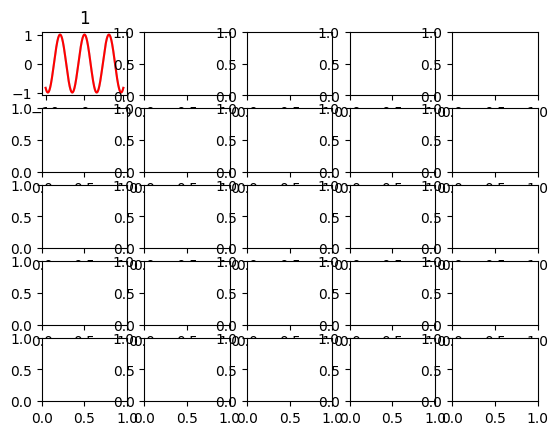

In [52]:
x = np.linspace(-10, 10, 1000)
y = np.cos(x)
g = gplearn()
print(g.fit(x, y).inorder_traversal())


##second function:
    y = np.sin(x)

Generation 1, Best Fitness: -0.0
( sin ( x ))


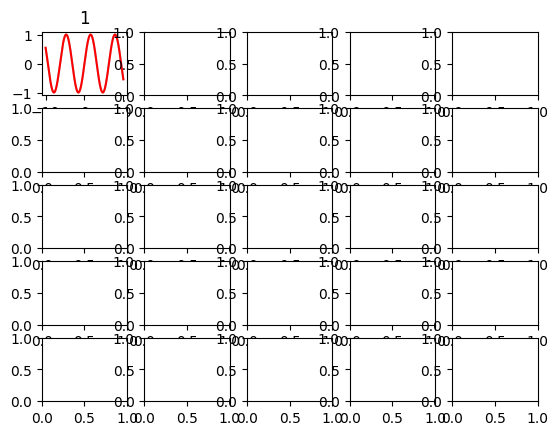

In [51]:
x = np.linspace(-10, 10, 1000)
y = np.sin(x)
g = gplearn()
print(g.fit(x, y).inorder_traversal())


##third function:
    y = x ^ 2

Generation 1, Best Fitness: -0.0
( 3 )


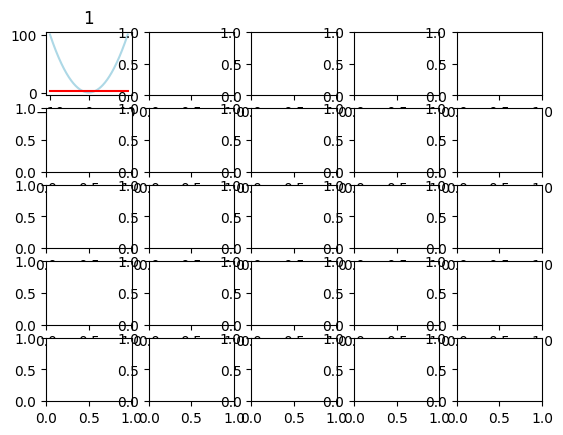

In [44]:
x = np.linspace(-10, 10, 1000)
y = x ** 2
g = gplearn()
print(g.fit(x, y).inorder_traversal())

##forth function:
  y = 3x - 4


Generation 1, Best Fitness: -16.0
Generation 2, Best Fitness: -16.0
Generation 3, Best Fitness: -16.0
Generation 4, Best Fitness: -16.0
Generation 5, Best Fitness: -16.0
Generation 6, Best Fitness: -16.0
Generation 7, Best Fitness: -16.0
Generation 8, Best Fitness: -16.0
Generation 9, Best Fitness: -16.0
Generation 10, Best Fitness: -16.0
Generation 11, Best Fitness: -16.0
Generation 12, Best Fitness: -16.0
Generation 13, Best Fitness: -16.0
Generation 14, Best Fitness: -16.0
Generation 15, Best Fitness: -16.0
Generation 16, Best Fitness: -16.0
Generation 17, Best Fitness: -16.0
Generation 18, Best Fitness: -16.0
Generation 19, Best Fitness: -16.0
Generation 20, Best Fitness: -16.0
Generation 21, Best Fitness: -16.0
Generation 22, Best Fitness: -16.0
Generation 23, Best Fitness: -16.0
Generation 24, Best Fitness: -16.0
Generation 25, Best Fitness: -16.0
(( x ) * ( 3 ))


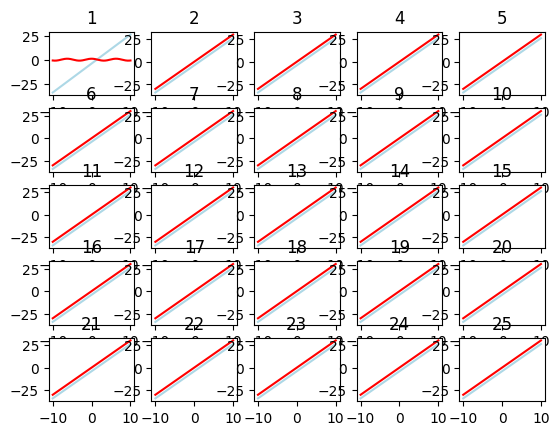

In [53]:
x = np.linspace(-10, 10, 1000)
y = 3*x - 4
g = gplearn()
print(g.fit(x, y).inorder_traversal())

## fifth function:
  y = x^2 + x

Generation 1, Best Fitness: -33.340000666733346
Generation 2, Best Fitness: -33.340000666733346
Generation 3, Best Fitness: -33.340000666733346
Generation 4, Best Fitness: -33.340000666733346
Generation 5, Best Fitness: -33.340000666733346
Generation 6, Best Fitness: -33.340000666733346
Generation 7, Best Fitness: -33.340000666733346
Generation 8, Best Fitness: -33.340000666733346
Generation 9, Best Fitness: -33.340000666733346
Generation 10, Best Fitness: -33.340000666733346
Generation 11, Best Fitness: -33.340000666733346
Generation 12, Best Fitness: -33.340000666733346
Generation 13, Best Fitness: -33.340000666733346
Generation 14, Best Fitness: -33.340000666733346
Generation 15, Best Fitness: -33.340000666733346
Generation 16, Best Fitness: -33.340000666733346
Generation 17, Best Fitness: -33.340000666733346
Generation 18, Best Fitness: -33.340000666733346
Generation 19, Best Fitness: -33.340000666733346
Generation 20, Best Fitness: -33.340000666733346
Generation 21, Best Fitness: 

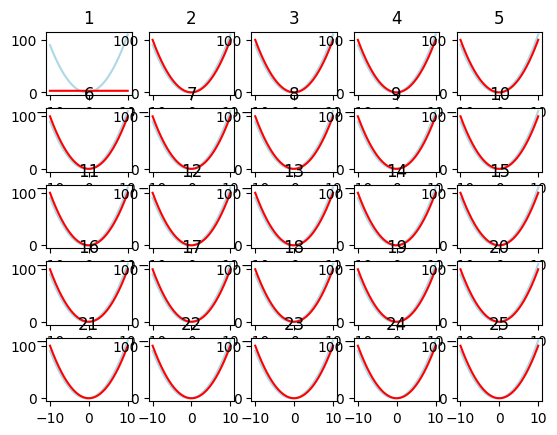

In [56]:
x = np.linspace(-10, 10, 10000)
y = x + x**2
g = gplearn()
print(g.fit(x, y).inorder_traversal())

##sixth function:
    y = x ^ 3

Generation 1, Best Fitness: -0.0
(( x ) + ( sin (( x ) - (( cos ( x )) + (( x ) - ( -5 ))))))


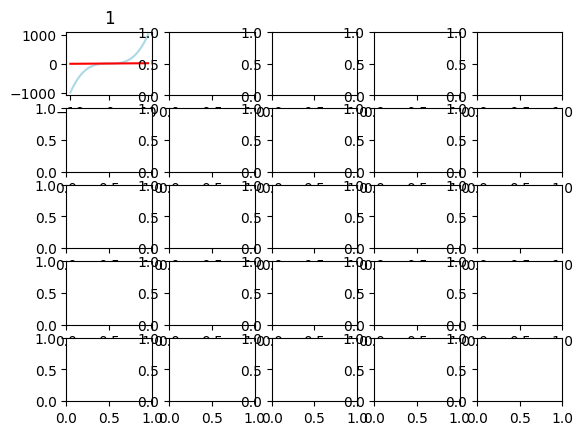

In [45]:
x = np.linspace(-10, 10, 10000)
y = x ** 3
g = gplearn()
print(g.fit(x, y).inorder_traversal())

##seventh function:
  y = np.tan(x)

Generation 1, Best Fitness: -7571.826393431759
Generation 2, Best Fitness: -7571.826393431759
Generation 3, Best Fitness: -7571.826393431759
Generation 4, Best Fitness: -7571.826393431759
Generation 5, Best Fitness: -7571.826393431759
Generation 6, Best Fitness: -7571.826393431759
Generation 7, Best Fitness: -7571.826393431759
Generation 8, Best Fitness: -7571.826393431759
Generation 9, Best Fitness: -7571.826393431759
Generation 10, Best Fitness: -7571.826393431759
Generation 11, Best Fitness: -7571.826393431759
Generation 12, Best Fitness: -7571.826393431759
Generation 13, Best Fitness: -7571.826393431759
Generation 14, Best Fitness: -7571.826393431759
Generation 15, Best Fitness: -7571.826393431759
Generation 16, Best Fitness: -7571.826393431759
Generation 17, Best Fitness: -7571.826393431759
Generation 18, Best Fitness: -7571.826393431759
Generation 19, Best Fitness: -7571.826393431759
Generation 20, Best Fitness: -7571.826393431759
Generation 21, Best Fitness: -7571.826393431759
G

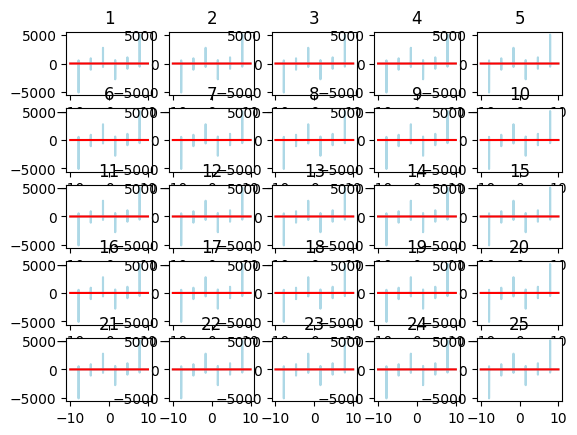

In [59]:
x = np.linspace(-10, 10, 10000)
y = np.tan(x)
g = gplearn()
print(g.fit(x, y).inorder_traversal())

##eighth function:
  y = x - 4

Generation 1, Best Fitness: -0.0
((( x ) + ( 0 )) - ( 5 ))


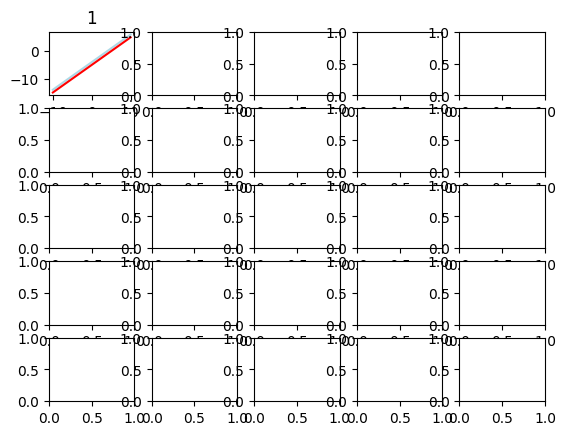

In [60]:
x = np.linspace(-10, 10, 10000)
# y = np.linspace(0, 10, 10000)
y = x - 4
g = gplearn()
print(g.fit(x, y).inorder_traversal())

##ninth function:
    y = 4x^2 + 4x + 1

Generation 1, Best Fitness: -18078.49203178443
Generation 2, Best Fitness: -18078.49203178443
Generation 3, Best Fitness: -18078.49203178443
Generation 4, Best Fitness: -18078.49203178443
Generation 5, Best Fitness: -18078.49203178443
Generation 6, Best Fitness: -18078.49203178443
Generation 7, Best Fitness: -18078.49203178443
Generation 8, Best Fitness: -18078.49203178443
Generation 9, Best Fitness: -18078.49203178443
Generation 10, Best Fitness: -18078.49203178443
Generation 11, Best Fitness: -18078.49203178443
Generation 12, Best Fitness: -18078.49203178443
Generation 13, Best Fitness: -18078.49203178443
Generation 14, Best Fitness: -18078.49203178443
Generation 15, Best Fitness: -18078.49203178443
Generation 16, Best Fitness: -18078.49203178443
Generation 17, Best Fitness: -18078.49203178443
Generation 18, Best Fitness: -18078.49203178443
Generation 19, Best Fitness: -18078.49203178443
Generation 20, Best Fitness: -18078.49203178443
Generation 21, Best Fitness: -18078.49203178443
G

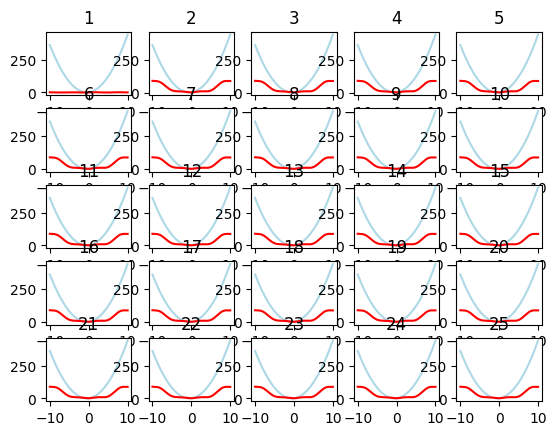

In [62]:
x = np.linspace(-10, 10, 10000)
y = 4* x ** 2 + 4 * x + 1
g = gplearn()
print(g.fit(x, y).inorder_traversal())

##random function for calculating with genetic algorithm

Generation 1, Best Fitness: -42.51066805379961
Generation 2, Best Fitness: -42.51066805379961
Generation 3, Best Fitness: -42.51066805379961
Generation 4, Best Fitness: -42.51066805379961
Generation 5, Best Fitness: -42.51066805379961
Generation 6, Best Fitness: -42.51066805379961
Generation 7, Best Fitness: -42.51066805379961
Generation 8, Best Fitness: -42.51066805379961
Generation 9, Best Fitness: -42.51066805379961
Generation 10, Best Fitness: -42.51066805379961
Generation 11, Best Fitness: -42.51066805379961
Generation 12, Best Fitness: -42.51066805379961
Generation 13, Best Fitness: -42.51066805379961
Generation 14, Best Fitness: -42.51066805379961
Generation 15, Best Fitness: -42.51066805379961
Generation 16, Best Fitness: -42.51066805379961
Generation 17, Best Fitness: -42.51066805379961
Generation 18, Best Fitness: -42.51066805379961
Generation 19, Best Fitness: -42.51066805379961
Generation 20, Best Fitness: -42.51066805379961
Generation 21, Best Fitness: -42.51066805379961
G

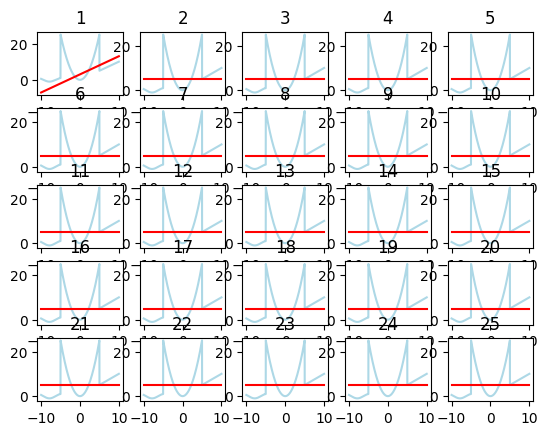

In [46]:
def random_function(x):
    result = np.zeros_like(x)

    result[x < -5] = np.sin(x[x < -5])
    result[(x >= -5) & (x <= 5)] = x[(x >= -5) & (x <= 5)] ** 2
    result[x > 5] = x[x > 5]

    return result

x = np.linspace(-10, 10, 1000)
y = random_function(x)
g = gplearn()
print(g.fit(x, y).inorder_traversal())

Generation 1, Best Fitness: -0.0
( -1 )


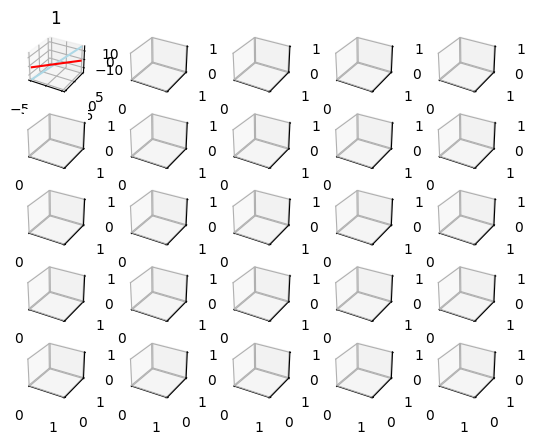

In [47]:
x = np.linspace(-5, 5, 1000)
y = np.linspace(-5, 5, 1000)
z = x * 2 + y
g = gplearn(dimensions=3)
print(g.fit(x, y, z).inorder_traversal())